# Policy Gradient

In reinforcement learning, the goal is to find a policy $\pi_\theta(a|s)$ that maximizes the expected cumulative reward. Policy Gradient (PG) methods are a class of algorithms for finding such policies in which the policy is represented by a parameterized function, such as a neural network. The key idea behind PG methods is that the gradient of the expected reward can be rephrased as the expected gradient of rewards times log-probabilities (the log-d trick):

$$ \nabla_\theta\,\operatorname*{\mathbb{E}}_{s,\ a \sim \pi_\theta}\, \text{rewards} = \operatorname*{\mathbb{E}}_{s,\ a \sim \pi_\theta}\, \text{rewards} \cdot \nabla_\theta \log \pi_\theta(a|s) $$

PG methods differ in:
- how $ \operatorname*{\mathbb{E}}_{s,\ a \sim \pi_\theta}$ is defined and approximated (how trajectory samples are collected and batched in gradient descent steps),
- what expression is used for *rewards* (with relative advantage estimates, value functions, etc.).

In its simplest form, we estimate the gradient with a sample of recent transitions, which were sampled according to the policy, and the PG is equal to:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

Where:
- $p^{\pi}_{*}$ is the distribution of states obtained by rolling out the policy $\pi_{\theta}(a|s)$.
- $Q^{\pi} (s, a)$ denotes the discounted Q-value under policy.

Other popular PG variants are the Actor-Critic and PPO.

Tasks:

1. Run the **PolicyGradient** agent and plot mean+std of rewards (as it progresses through training).
2. Implement the *compute_pseudo_loss* method for the **BaselinedPolicyGradient** class.
3. Implement the *compute_pseudo_loss* method for the **ActorCritic** class.

Each training takes ~3 minutes on Colab CPU (GPUs won't help).

In [34]:
# %pip install gymnasium

In [35]:
import time
from dataclasses import dataclass
from typing import SupportsFloat

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor

In [36]:
# Check for CUDA / MPS (Apple) / XPU (Intel) / ... accelerator.
device = torch.accelerator.current_accelerator(True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

False cpu


## Configuration

In [37]:
@dataclass
class Config:
    # Do not change!

    gym_id: str = "CartPole-v1"
    buffer_size: int = 32  # Number of transitions to store in the transition buffer.
    hidden_dim: int = 32  # Size of hidden layer in policy and value networks.
    policy_learning_rate: float = 5e-3
    value_learning_rate: float = 1e-2
    discount: float = 0.99  # Gamma discount factor in definition of Q and V values.
    n_train_steps: int = 10_000
    n_trainings: int = 10
    n_eval_samples: int = 20  # Number of episodes rolled-out in each evaluation.
    steps_between_evals: int = 2000  # How often to evaluate during training.
    device: torch.device = device

    def __post_init__(self):
        env = gym.make(self.gym_id)

        # Observation, consisting of: position, velocity, angle, angular velocity.
        assert isinstance(env.observation_space, gym.spaces.Box)
        self.obs_size = env.observation_space.shape[0]

        # Two actions: left and right.
        assert isinstance(env.action_space, gym.spaces.Discrete)
        self.action_size = int(env.action_space.n)


config = Config()

## Plotter

In [38]:
class Plotter:
    """Collects and plots rewards curves for each experiment."""

    def __init__(self, config: Config) -> None:
        self.config = config
        # Maps experiment name to list of curves (from different training seeds).
        # Each curve is a list of mean total rewards in evaluations done during training.
        self.data = dict[str, list[list[float]]]()

    def reset(self) -> None:
        self.data = dict[str, list[list[float]]]()

    def add_rewards_curve(self, label: str, rewards_curve: list[float]) -> None:
        """Plot any number of reward curves, ."""
        if label not in self.data:
            self.data[label] = []
        self.data[label].append(rewards_curve)

    def show(self) -> None:
        for label, rewards_list in self.data.items():
            average_rewards = np.mean(rewards_list, axis=0)

            x = np.linspace(0, 100, len(average_rewards))
            plt.plot(x, average_rewards, label=label)

        plt.ylim(bottom=0, top=400)
        plt.legend(loc="upper left")
        plt.xlabel("Training Progress [%]")
        plt.ylabel("Reward (mean across trainings)")
        plt.show()


plotter = Plotter(config)

## Networks

We define a policy network (**ActorNetwork**) and a value network (**CriticNetwork**), with helper methods to work directly with numpy.ndarray observations.

In [39]:
class ActorNetwork(nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config.obs_size, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.action_size),
        )

    def forward(self, obs: Tensor) -> Tensor:
        """
        Input: observation, shape (batch_size, obs_size).
        Output: logits for action probabilities, shape (batch_size, action_size).
        """
        return self.layers(obs)  # No softmax here.

    def sample_action(self, obs: np.ndarray) -> tuple[Tensor, Tensor]:
        """
        Sample an action for a given observation of shape (batch_size, obs_size).

        Returns:
        - action: sampled action, shape (batch_size,), dtype int.
        - logprob: log prob. of that action, shape (batch_size,), differentiable wrt actor params.
        """
        batch_size, _obs_size = obs.shape
        device = next(self.parameters()).device
        logits = self(Tensor(obs, device=device))
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample((batch_size,))
        return action, dist.log_prob(action)


class CriticNetwork(nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config.obs_size, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, 1),
        )

    def forward(self, obs: Tensor) -> Tensor:
        """
        Input: observation, shape (batch_size, obs_size).
        Output: V value estimate, shape (batch_size,).
        """
        return torch.squeeze(self.layers(obs), -1)

    def get_value(self, obs: np.ndarray) -> Tensor:
        """Given obs of shape (batch_size, obs_size), return value estimate, shape (batch_size,)."""
        device = next(self.parameters()).device
        return self(Tensor(obs, device=device))

## Buffer
We maintain a buffer (a.k.a. batch) of recent transitions, to make updates averaged over multiple transitions.
The buffer is small (buffer_size=32 vs episode length ~200), not like the experience replay buffer from DQN.
We add to it until it is full, use it to make an update, and then clear it; repeat.

The buffer defines a method for calculating Q-values: as sums of rewards (discounted).
Since the buffer is small, we will never have a full episode in the buffer, so we need an estimate of rewards post final state in the buffer.
We get such an estimate from the value network (critic).
This will be the only use of the value network, for the first algorithm.

In [40]:
class Buffer:
    def __init__(self, buffer_size: int, device: torch.device) -> None:
        self.buffer_size = buffer_size
        self.device = device
        self.reset()

    def reset(self) -> None:
        buffer_size, device = self.buffer_size, self.device
        self.logprobs = torch.zeros(buffer_size, device=device)
        self.values = torch.zeros(buffer_size, device=device)
        self.rewards = torch.zeros(buffer_size, device=device)
        self.terminals = torch.zeros(buffer_size, dtype=torch.bool, device=device)
        self.idx = 0

    def add(
        self,
        logprob: Tensor,
        value: Tensor,
        reward: SupportsFloat,
        terminal: SupportsFloat,
    ) -> None:
        """Called after each train episode step (with differentiable logprob and value scalars)."""
        self.logprobs[self.idx] = logprob
        self.values[self.idx] = value
        self.rewards[self.idx] = float(reward)
        self.terminals[self.idx] = float(terminal)
        self.idx += 1

    def get_qvalues(self, final_value: Tensor, discount: float = 1.0) -> Tensor:
        """
        Return Q-values for the buffer (discounted sum of rewards), shape (buffer_size,).

        Args:
        - final_value: V value estimate for the final state, scalar.
        - discount: gamma in the definition of Q-values.
        """
        q_values = torch.zeros_like(self.rewards).to(self.rewards.device)

        next_value = final_value
        for timestep in reversed(range(self.buffer_size)):
            if self.terminals[timestep]:
                next_value = 0.0

            q_values[timestep] = self.rewards[timestep] + discount * next_value
            next_value = q_values[timestep]

        return q_values

## PolicyGradient trainer

In [41]:
class PolicyGradient:
    def __init__(self, config: Config) -> None:
        super().__init__()
        self.config = config
        self.buffer = Buffer(config.buffer_size, device=config.device)
        self.init_networks()

    def init_networks(self) -> None:
        self.actor = ActorNetwork(self.config).to(self.config.device)
        self.critic = CriticNetwork(self.config).to(self.config.device)
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(),
            lr=self.config.policy_learning_rate,
        )
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),
            lr=self.config.value_learning_rate,
        )
        self.buffer.reset()

    def evaluate(self) -> float:
        """Rollout `samples` episodes. Return the average total reward."""
        self.actor.eval()
        self.critic.eval()
        with torch.no_grad():
            env_test = gym.make(self.config.gym_id)
            total_reward = 0.0
            for _ in range(self.config.n_eval_samples):
                obs, _info = env_test.reset()
                episode_reward = 0.0
                while True:
                    action, _logprobs = self.actor.sample_action(obs[np.newaxis, :])
                    next_obs, reward, terminal, truncated, _info = env_test.step(
                        action.item()
                    )
                    done = terminal or truncated
                    episode_reward += float(reward)
                    obs = next_obs
                    if done:
                        break
                total_reward += episode_reward
        return total_reward / self.config.n_eval_samples

    def train(self, seed: int) -> list[float]:
        """Trains the agent and returns (timesteps // steps_between_evals) evaluation rewards."""
        env = gym.make(self.config.gym_id)
        obs, _ = env.reset(seed=seed)

        start_time = time.time()
        eval_rewards = list[float]()

        for step in range(config.n_train_steps):
            self.actor.train()
            self.critic.train()

            value = self.critic.get_value(obs[np.newaxis, :])
            action, logprob = self.actor.sample_action(obs[np.newaxis, :])
            next_obs, reward, terminal, truncated, _ = env.step(action.item())
            done = terminal or truncated
            self.buffer.add(logprob, value, reward, done)
            obs = next_obs

            if self.buffer.idx == self.config.buffer_size:
                self.update(obs)

            if done:
                obs, _info = env.reset(seed=seed)

            # Evaluate every steps_between_evals.
            if (step + 1) % self.config.steps_between_evals == 0:
                eval_reward = self.evaluate()
                eval_rewards.append(eval_reward)
                samples_per_sec = (step + 1) / (time.time() - start_time)
                if (step + 1) % (10 * self.config.steps_between_evals) == 0:
                    print(f"{step+1=}, {eval_reward=:.1f}, {samples_per_sec=:.0f}")

        return eval_rewards

    def update(self, final_obs: np.ndarray) -> None:
        # Final-value and hence target q-values depend on critic parameters,
        # but we do not want to backprop through it
        # (neither in the critic nor in the actor update)!
        with torch.no_grad():
            final_value = self.critic.get_value(final_obs[np.newaxis, :])
            q_values = self.buffer.get_qvalues(final_value, self.config.discount)

        self.critic_optimizer.zero_grad()
        value_loss = (self.buffer.values - q_values).pow(2).mean()
        value_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        pseudo_loss = self.compute_pseudo_loss(q_values)
        pseudo_loss.backward()
        self.actor_optimizer.step()

        self.buffer.reset()

    def compute_pseudo_loss(self, q_values: Tensor) -> Tensor:
        """Compute pseudo-loss for the policy (actor) network, using the collected buffer."""
        return -(q_values * self.buffer.logprobs).mean()

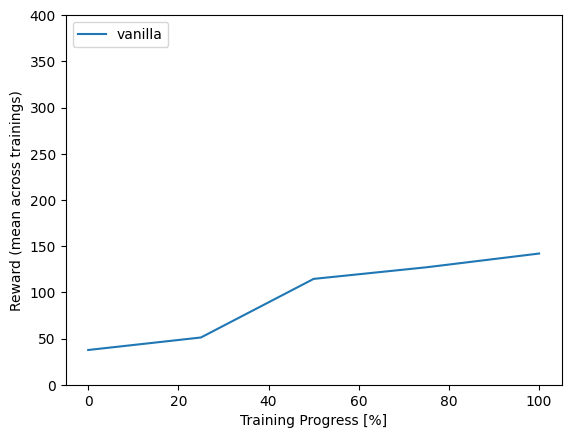

In [42]:
for i in range(config.n_trainings):
    plotter.add_rewards_curve("vanilla", PolicyGradient(config).train(i))
plotter.show()

## PG with baseline

The vanilla PG estimate has big variance – it will vary a lot depending on the states and actions sampled.
This variance is known to impact the sample efficiency and final performance of the agent.
Although there are many strategies fo PG variance reduction, there is one trick that became indispensable in modern implementations of PG – the baseline. But before we get to this, lets have one more look at the vanilla PG estimate:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

As discussed in the lecture, the idea of PG is quite simple – increase the probability of good actions and decrease the probability of bad ones.
'Good' and 'bad' here refer to Q-values associated with given actions. But what if all Q-values are positive? The gradient update will try to increase the logits of all sampled actions, with the increase being proportional to the Q-value (as stems from the equation above). As such, given positive Q-values, the logits of bad actions are also increased – just by a smaller amount that logits of actions with bigger Q-values.

Baseline variance reduction tackles exactly that. The idea is to subtract a "baseline" from the Q-values, which does not affect the optimal policy, but reduces the variance of the gradients. It is proven that as long as the baseline does not depend on the action, its value will not bias the PG (a bad choice may increase the variance, though :)). So, what is a good baseline?

The simplest version subtracts batch average of Q-values from each Q-value:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \Bigl( Q^{\pi} (s_i, a_i) - \frac{\sum Q^{\pi} (s_i, a_i)}{B} \Bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where B is the batch size and $\frac{\sum Q^{\pi} (s_i, a_i)}{B}$ is the average Q-value in the batch.

In [43]:
class BaselinedPolicyGradient(PolicyGradient):
    def compute_pseudo_loss(self, q_values: Tensor) -> Tensor:
        ## TODO {
        q_values = q_values - q_values.mean()
        """Compute pseudo-loss for the policy (actor) network, using the collected buffer."""
        return -(q_values * self.buffer.logprobs).mean()
        ## }

In [ ]:
for i in range(config.n_trainings):
    plotter.add_rewards_curve("mean baseline", BaselinedPolicyGradient(config).train(i))
plotter.show()

## Actor-Critic

The most popular approach is to use the state V value, estimated by a value network (*CriticNetwork*), as the baseline. Then, the gradient is well centered – probabilities of actions with Q-values smaller than state value will be decreased, while probabilities of actions with Q-values bigger than state value will be increased. Traditionally, PG variants that use a value network for baseline variance reduction are called Actor-Critic. The Actor-Critic update is calculated as:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where $\bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr)$ is referred to as the **advantage**.

In [ ]:
class ActorCritic(PolicyGradient):
    def compute_pseudo_loss(self, q_values: Tensor) -> Tensor:
        ## TODO {
        q_values = q_values - self.buffer.rewards
        """Compute pseudo-loss for the policy (actor) network, using the collected buffer."""
        return -(q_values * self.buffer.logprobs).mean()
        ## }


In [ ]:
for i in range(config.n_trainings):
    plotter.add_rewards_curve("V baseline", ActorCritic(config).train(i))
plotter.show()